# Nachbearbeitung für membranbasierte Zellsegmentierung
In diesem Notebook verwenden wir einen Seeded-Watershed-Algorithmus von [napari-segment-blobs-and-things-with-membranes](https://github.com/haesleinhuepf/napari-segment-blobs-and-things-with-membranes), um Zellen zu segmentieren und anschließend zu filtern, um fälschlicherweise segmentierte Objekte zu entfernen.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread

import pyclesperanto_prototype as cle
import napari_segment_blobs_and_things_with_membranes as nsbatwm

Die folgenden Beispielbilddaten sind eine Zeitreihe von Zellen, die mit einem Membranmarker markiert sind. Der Datensatz ist eine Zurverfügungstellung von Sascha M. Kuhn, Nadler Lab, MPI-CBG Dresden.

In [2]:
image_timelapse = imread("../../data/membrane_2d_timelapse.tif")
image_timelapse.shape

(5, 256, 256)

Wir beginnen damit, ein einzelnes Kanal-, Einzelzeitpunkt-Beispiel aus der Mitte des Zeitreihen-Stacks zu extrahieren.

In [3]:
membranes_single_slice = image_timelapse[2]
membranes_single_slice.shape

(256, 256)

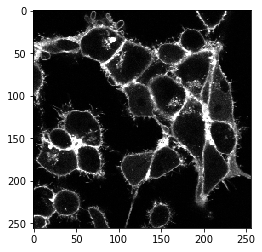

In [4]:
cle.imshow(membranes_single_slice)

Das napari-segment-blobs-and-things-with-membranes Plugin ist skriptfähig. Alle Befehle, die aus dem Menü aufgerufen werden können, können auch von Python aus aufgerufen werden. Zum Beispiel kann der lokale-Minima-Seeded-Watershed wie folgt aufgerufen werden:

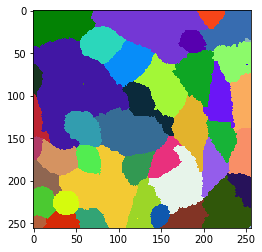

In [5]:
cell_labels_pre = nsbatwm.local_minima_seeded_watershed(membranes_single_slice, spot_sigma=7)

cle.imshow(cell_labels_pre, labels=True)

Offensichtlich werden nach diesem Schritt zu viele Objekte segmentiert und markiert. Daher sollten wir untersuchen, welche Eigenschaften dieser Zellen es uns ermöglichen, echte Zellen und segmentierten Hintergrund zu unterscheiden. Da die Zellen beispielsweise auch vorne und hinten Membran haben, nehmen wir dieses Signal als höhere Intensität in echten Zellen wahr. Um dies quantitativ zu visualisieren, erstellen wir eine Karte der mittleren Intensität der Zellen. In dieser Karte erhält jeder Pixel, der zu einer bestimmten Zelle gehört, die durchschnittliche Signalintensität der gesamten Zelle.

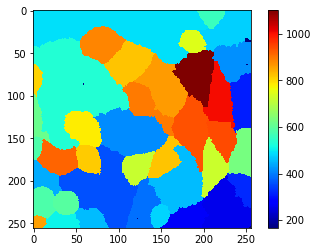

In [6]:
mean_intensity_map = cle.mean_intensity_map(membranes_single_slice, cell_labels_pre)

cle.imshow(mean_intensity_map, colorbar=True, colormap='jet')

Aus dieser Ansicht und der Farbskala an der Seite können wir einen Schwellenwert schätzen, z.B. `650`, der es uns ermöglicht, echte Zellen vom Hintergrund zu trennen. Wenn eine solche einfache Schwellenwertmethode nicht funktioniert und/oder ein einzelner Parameter wie die mittlere Intensität diese Unterscheidung nicht zulässt, kann es sinnvoll sein, Objektklassifikatoren, auch bekannt als maschinelles Lernen, zu verwenden. Zum Beispiel können das [napari-accelerate-pixel-and-object-classification](https://www.napari-hub.org/plugins/napari-accelerated-pixel-and-object-classification) Plugin und die zugrunde liegende [apoc-Bibliothek](https://github.com/haesleinhuepf/apoc) helfen.

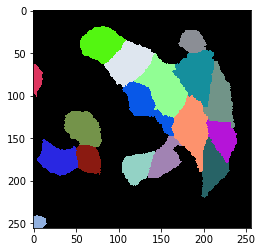

In [7]:
cell_labels = cle.exclude_labels_with_map_values_within_range(mean_intensity_map, cell_labels_pre, maximum_value_range=700)

cle.imshow(cell_labels, labels=True)

## Anwendung des Workflows auf die gesamte Zeitreihe
Wir haben jetzt eine grobe Vorstellung davon, wie ein Workflow zur Segmentierung der Zellen aussieht. Wir schreiben den gesamten Workflow in eine Funktion um. Die Funktion hat auch eine ordentliche Dokumentation, damit das zukünftige Ich noch weiß, was die Funktion tut.

In [8]:
def cell_segmentation_worflow(membranes_single_slice, cell_segmentation_spot_sigma=7, maximum_mean_intensity_per_cell=700):
    """Zellsegmentierung basierend auf Membransignal
    
    Parameter
    ----------
    membranes_single_slice
        Zu segmentierendes Bild
    cell_segmentation_spot_sigma: float, optional
        Ermöglicht die Konfiguration der Segmentierung. Je höher Sigma, desto weniger Zellen werden vorhanden sein.
    maximum_mean_intensity_per_cell: float, optional
        Schwellenwert für die mittlere Intensität pro Zelle. Zellen mit Signal darunter werden ausgeschlossen
        
    Rückgabe
    -------
    Zell-Label-Bild
    """
    
    # Zellkandidaten markieren
    cell_labels_pre = nsbatwm.local_minima_seeded_watershed(
                                membranes_single_slice, 
                                spot_sigma=cell_segmentation_spot_sigma)
    
    # Intensität in allen Kandidaten messen
    mean_intensity_map = cle.mean_intensity_map(
                                membranes_single_slice, 
                                cell_labels_pre)
    
    # Kandidaten mit niedrigem Signal ausschließen
    cell_labels = cle.exclude_labels_with_map_values_within_range(
                        mean_intensity_map, cell_labels_pre, 
                        maximum_value_range=maximum_mean_intensity_per_cell)
    
    return cell_labels

Diese Funktion können wir auf die gesamte Zeitreihe anwenden und überprüfen, ob die Segmentierung auch in allen Zeitpunkten gut funktioniert.

t =  0 , number of cells:  17.0


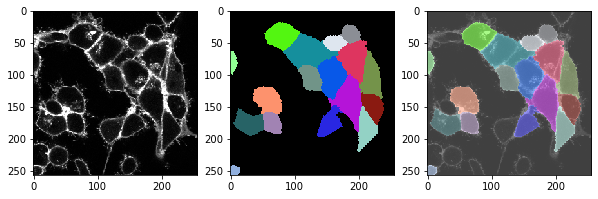

t =  1 , number of cells:  18.0


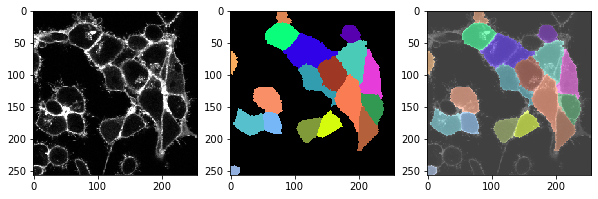

t =  2 , number of cells:  17.0


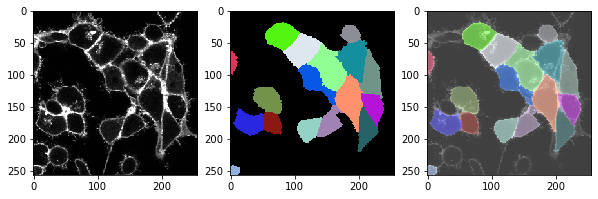

t =  3 , number of cells:  18.0


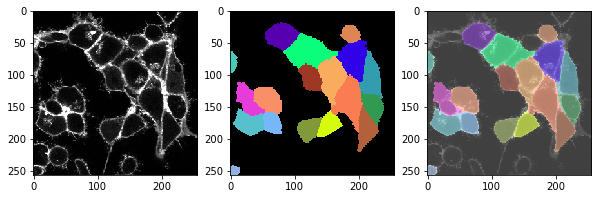

t =  4 , number of cells:  17.0


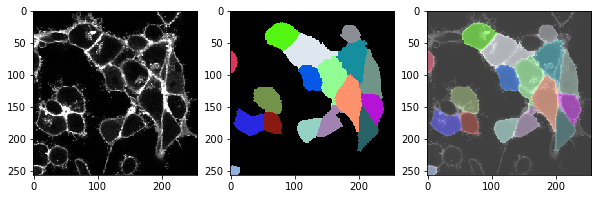

In [9]:
for t in range(len(image_timelapse)):
    # einzelne Scheibe / Zeitpunkt extrahieren
    membranes_single_slice = image_timelapse[t]
    
    # Zellen segmentieren 
    cell_labels = cell_segmentation_worflow(membranes_single_slice)

    # Überschrift ausgeben
    print("t = ", t, ", Anzahl der Zellen: ", cell_labels.max())
    
    # drei Bilder anzeigen: Bild, Labels, Überlagerung
    fix, axs = plt.subplots(1, 3, figsize=(10,10))
    
    cle.imshow(membranes_single_slice, plot=axs[0])
    cle.imshow(cell_labels, plot=axs[1], labels=True)
    cle.imshow(membranes_single_slice, plot=axs[2], alpha=0.5, continue_drawing=True)
    cle.imshow(cell_labels, plot=axs[2], labels=True, alpha=0.5)
    plt.show()
    

## Übung
Anstatt Zellen mit niedriger Signalintensität herauszufiltern, filtern Sie Zellen heraus, die groß sind und/oder den Bildrand berühren. Wenden Sie den neuen Workflow auf die gesamte Zeitreihe an.